# Digit Recognizer by Neural Network

`神经网络` 训练识别手写数字体

`Accuracy:` 96.64%

`Time:` 386.67s

---

Created on 2019-05-24

Update  on 2019-05-26

Author: 家丞

Github: https://github.com/Jiachengciel/Kaggle


---

## 一. 基础环境配置

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

---

## 二. 数据分析

### 2.1 数据导入 

In [2]:
# Load the data
train_data = pd.read_csv("input/train.csv")

# Classify the data
Y_data = train_data.label
X_data = train_data.drop(labels=['label'], axis=1)

# Free some space
del train_data

print("Number of examples: {}, shape of input: {}".format(X_data.shape[0], X_data.shape))


Number of examples: 42000, shape of input: (42000, 784)


### 2.2 数据可视化

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

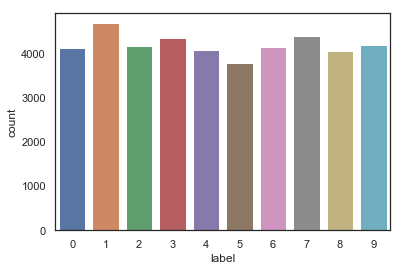

In [3]:
g = sns.countplot(Y_data)
Y_data.value_counts()

---

## 三. 特征工程

### 3.1 检查缺失值

In [4]:
X_data.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### 3.2 标准化

In [5]:
X_np = X_data.values / 255 
Y_np = Y_data.values

### 3.3 分割训练集和测试集

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X_np, Y_np,
                                                   test_size=0.2,
                                                   random_state=16)
print("Quantity of examples in Train: {}\nQuantity of examples in Test: {}".format(X_train.shape[0], X_test.shape[0]))

Quantity of examples in Train: 33600
Quantity of examples in Test: 8400


### 3.4 转换为Tensor形式

In [7]:
X_Train = torch.from_numpy(X_train)
Y_Train = torch.from_numpy(Y_train).type(torch.LongTensor)

X_Test = torch.from_numpy(X_test)
Y_Test = torch.from_numpy(Y_test).type(torch.LongTensor)

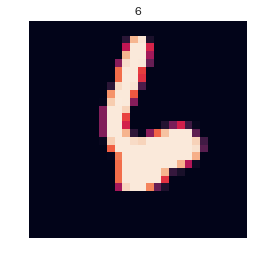

In [8]:
# 可视化
plt.imshow(X_np[26].reshape(28,28))
plt.axis('off')
plt.title(str(Y_np[26]))
plt.show()

---

## 四. 模型选择和使用

### 4.1 定义参数

In [9]:
BATCH_SIZE = 50
EPOCH = 15

Input_dim = 28*28
Hidden1_dim = 250
Hidden2_dim = Hidden3_dim = 100
Output_dim = 10

Learning_Rate = 0.02

### 4.2 载入数据

In [10]:
train = torch.utils.data.TensorDataset(X_Train, Y_Train)
test = torch.utils.data.TensorDataset(X_Test, Y_Test)

train_loader = torch.utils.data.DataLoader(train, BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, BATCH_SIZE, shuffle=False)


### 4.3 定义模型

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self, Input_dim, Hidden1_dim, Hidden2_dim, Hidden3_dim, Output_dim):
        super(NeuralNetwork, self).__init__()
        
        self.NN = nn.Sequential(
            # 1 layer: 784 --> 250
            nn.Linear(Input_dim, Hidden1_dim),
            nn.ReLU(),
            # 2 layer: 250 --> 100
            nn.Linear(Hidden1_dim, Hidden2_dim),
            nn.Tanh(),
            # 3 layer: 100 --> 100
            nn.Linear(Hidden2_dim, Hidden3_dim),
            nn.ELU(),
        )
         # 4 layer: 100 --> 10
        self.out = nn.Linear(Hidden3_dim, Output_dim)
        
    def forward(self, x):
        y = self.NN(x)
        out = self.out(y)
        return out
    
model = NeuralNetwork(Input_dim, Hidden1_dim, Hidden2_dim, Hidden3_dim, Output_dim)
error = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=Learning_Rate)

print(model)

NeuralNetwork(
  (NN): Sequential(
    (0): Linear(in_features=784, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
  )
  (out): Linear(in_features=100, out_features=10, bias=True)
)


### 4.4 训练模型

In [12]:
count = 0
loss_list =[]
iteration_list = []
accuracy_list = []
start = time.clock()

for epoch in range(EPOCH):
    for step, (images, labels) in enumerate(train_loader):
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward 
        outputs = model(train.float())
        
        # Calculate the loss
        loss = error(outputs, labels)
        
        # Backward
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate accuracy
            correct = 0
            
            for images, labels in test_loader:
                test = Variable(images.view(-1, 28*28))
                
                outputs = model(test.float())
                
                # 提取indices
                predicted = torch.max(outputs.data, 1)[1]
                
                correct += (predicted == labels).sum()
            
            accuracy = round(float(100 * correct.item() / float(X_test.shape[0])), 2)
            
            # Store loss and accuracy
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
            if count % 500 == 0:
                print('Iteration: {} Loss: {} Accuracy: {} %'.format(count, loss.data, accuracy))

                
end = time.clock()
print("运行时间：{} s".format(end-start))
                

Iteration: 500 Loss: 1.1888461112976074 Accuracy: 74.51 %
Iteration: 1000 Loss: 0.651594877243042 Accuracy: 87.43 %
Iteration: 1500 Loss: 0.3641195595264435 Accuracy: 89.65 %
Iteration: 2000 Loss: 0.1792561411857605 Accuracy: 90.9 %
Iteration: 2500 Loss: 0.3956226408481598 Accuracy: 91.7 %
Iteration: 3000 Loss: 0.16354869306087494 Accuracy: 92.68 %
Iteration: 3500 Loss: 0.21069036424160004 Accuracy: 93.42 %
Iteration: 4000 Loss: 0.18269020318984985 Accuracy: 94.13 %
Iteration: 4500 Loss: 0.11764658242464066 Accuracy: 94.48 %
Iteration: 5000 Loss: 0.03900475427508354 Accuracy: 94.95 %
Iteration: 5500 Loss: 0.16841179132461548 Accuracy: 95.39 %
Iteration: 6000 Loss: 0.1387794464826584 Accuracy: 95.57 %
Iteration: 6500 Loss: 0.058572303503751755 Accuracy: 95.85 %
Iteration: 7000 Loss: 0.047127190977334976 Accuracy: 95.9 %
Iteration: 7500 Loss: 0.03813285753130913 Accuracy: 96.19 %
Iteration: 8000 Loss: 0.06524886935949326 Accuracy: 96.19 %
Iteration: 8500 Loss: 0.029939480125904083 Accura

### 4.5 可视化训练过程

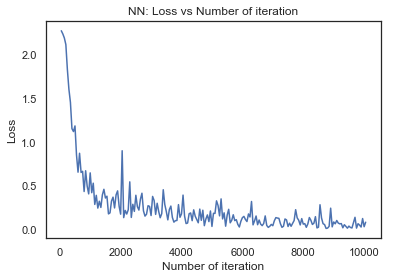

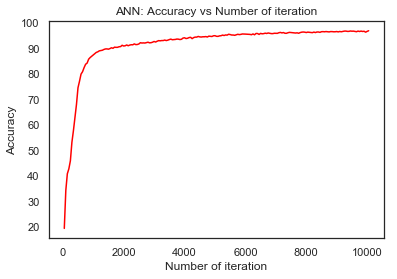

In [13]:
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("NN: Loss vs Number of iteration")
plt.show()

plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()
